# Deep Learning for Geo/Environmental sciences

<center><img src="../logo_2.png" alt="logo" width="600"/></center>

<em>*Created with ChapGPT</em>

## Lecture 4: Feature engineering

 - Multi-dimensional data and imagery with `xarray`
 - Handling missing data
 - Data layout, one-hot encoding etc.
 - Data scaling, normalization and infilling 
 - Feature selection

## Introduction to Xarray 


In this lesson, we discuss cover the basics of Xarray data structures. By the
end of the lesson, we will be able to:

- Understand the basic data structures in Xarray
- Inspect `DataArray` and `Dataset` objects.
- Read and write netCDF files using Xarray.
- Understand that there are many packages that build on top of xarray

## Data structures


We'll start by reviewing the various components of the Xarray data model, represented here visually:

<img src="https://docs.xarray.dev/en/stable/_images/dataset-diagram.png" align="center" width="60%">

Xarray has a few small real-world tutorial datasets hosted in the [xarray-data](https://github.com/pydata/xarray-data) GitHub repository.

[xarray.tutorial.load_dataset](https://docs.xarray.dev/en/stable/generated/xarray.tutorial.open_dataset.html#xarray.tutorial.open_dataset) is a convenience function to download and open DataSets by name (listed at that link).

Here we'll use `air temperature` from the [National Center for Environmental Prediction](https://www.weather.gov/ncep/). 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

ds = xr.tutorial.load_dataset("air_temperature")

Xarray objects have convenient HTML representations to give an overview of what we're working with:

In [4]:
ds

<xarray.Dataset>
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 241.2 242.5 243.5 ... 296.5 296.2 295.7
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

Note that behind the scenes the `tutorial.open_dataset` downloads a file. It then uses [`xarray.open_dataset`](https://docs.xarray.dev/en/stable/generated/xarray.open_dataset.html#xarray-open-dataset) function to open that file (which for this datasets is a [netCDF](https://www.unidata.ucar.edu/software/netcdf/) file). 

A few things are done automatically upon opening, but controlled by keyword arguments. For example, try passing the keyword argument `mask_and_scale=False`... what happens?

## What's in a Dataset? 

Datasets are dictionary-like containers of DataArrays. They are a mapping of
variable name to DataArray:

In [5]:
# pull out "air" dataarray with dictionary syntax
ds["air"]

<xarray.DataArray 'air' (time: 2920, lat: 25, lon: 53)>
array([[[241.2    , 242.5    , 243.5    , ..., 232.79999, 235.5    ,
         238.59999],
        [243.79999, 244.5    , 244.7    , ..., 232.79999, 235.29999,
         239.29999],
        [250.     , 249.79999, 248.89   , ..., 233.2    , 236.39   ,
         241.7    ],
        ...,
        [296.6    , 296.19998, 296.4    , ..., 295.4    , 295.1    ,
         294.69998],
        [295.9    , 296.19998, 296.79   , ..., 295.9    , 295.9    ,
         295.19998],
        [296.29   , 296.79   , 297.1    , ..., 296.9    , 296.79   ,
         296.6    ]],

       [[242.09999, 242.7    , 243.09999, ..., 232.     , 233.59999,
         235.79999],
        [243.59999, 244.09999, 244.2    , ..., 231.     , 232.5    ,
         235.7    ],
        [253.2    , 252.89   , 252.09999, ..., 230.79999, 233.39   ,
         238.5    ],
...
        [293.69   , 293.88998, 295.38998, ..., 295.09   , 294.69   ,
         294.29   ],
        [296.29   , 297.19   , 297.59   , ..., 295.29   , 295.09   ,
         294.38998],
        [297.79   , 298.38998, 298.49   , ..., 295.69   , 295.49   ,
         295.19   ]],

       [[245.09   , 244.29   , 243.29   , ..., 241.68999, 241.48999,
         241.79   ],
        [249.89   , 249.29   , 248.39   , ..., 239.59   , 240.29   ,
         241.68999],
        [262.99   , 262.19   , 261.38998, ..., 239.89   , 242.59   ,
         246.29   ],
        ...,
        [293.79   , 293.69   , 295.09   , ..., 295.29   , 295.09   ,
         294.69   ],
        [296.09   , 296.88998, 297.19   , ..., 295.69   , 295.69   ,
         295.19   ],
        [297.69   , 298.09   , 298.09   , ..., 296.49   , 296.19   ,
         295.69   ]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

You can save some typing by using the "attribute" or "dot" notation. This won't
work for variable names that clash with a built-in method name (like `mean` for
example).


In [6]:
# pull out dataarray using dot notation
ds.air

<xarray.DataArray 'air' (time: 2920, lat: 25, lon: 53)>
array([[[241.2    , 242.5    , 243.5    , ..., 232.79999, 235.5    ,
         238.59999],
        [243.79999, 244.5    , 244.7    , ..., 232.79999, 235.29999,
         239.29999],
        [250.     , 249.79999, 248.89   , ..., 233.2    , 236.39   ,
         241.7    ],
        ...,
        [296.6    , 296.19998, 296.4    , ..., 295.4    , 295.1    ,
         294.69998],
        [295.9    , 296.19998, 296.79   , ..., 295.9    , 295.9    ,
         295.19998],
        [296.29   , 296.79   , 297.1    , ..., 296.9    , 296.79   ,
         296.6    ]],

       [[242.09999, 242.7    , 243.09999, ..., 232.     , 233.59999,
         235.79999],
        [243.59999, 244.09999, 244.2    , ..., 231.     , 232.5    ,
         235.7    ],
        [253.2    , 252.89   , 252.09999, ..., 230.79999, 233.39   ,
         238.5    ],
...
        [293.69   , 293.88998, 295.38998, ..., 295.09   , 294.69   ,
         294.29   ],
        [296.29   , 297.19   , 297.59   , ..., 295.29   , 295.09   ,
         294.38998],
        [297.79   , 298.38998, 298.49   , ..., 295.69   , 295.49   ,
         295.19   ]],

       [[245.09   , 244.29   , 243.29   , ..., 241.68999, 241.48999,
         241.79   ],
        [249.89   , 249.29   , 248.39   , ..., 239.59   , 240.29   ,
         241.68999],
        [262.99   , 262.19   , 261.38998, ..., 239.89   , 242.59   ,
         246.29   ],
        ...,
        [293.79   , 293.69   , 295.09   , ..., 295.29   , 295.09   ,
         294.69   ],
        [296.09   , 296.88998, 297.19   , ..., 295.69   , 295.69   ,
         295.19   ],
        [297.69   , 298.09   , 298.09   , ..., 296.49   , 296.19   ,
         295.69   ]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

## What's in a DataArray? 

*data + (a lot of) metadata*

### Named dimensions 

`.dims` correspond to the axes of your data. 

In this case we have 2 spatial dimensions (`latitude` and `longitude` are store with shorthand names `lat` and `lon`) and one temporal dimension (`time`).

In [7]:
ds.air.dims

('time', 'lat', 'lon')

### Coordinate variables 

`.coords` is a simple [data container](https://docs.xarray.dev/en/stable/user-guide/data-structures.html#coordinates)
for coordinate variables.

Here we see the actual timestamps and spatial positions of our air temperature data:

In [8]:
ds.air.coords

Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00

Coordinates objects support similar indexing notation


In [9]:
# extracting coordinate variables
ds.air.lon

<xarray.DataArray 'lon' (lon: 53)>
array([200. , 202.5, 205. , 207.5, 210. , 212.5, 215. , 217.5, 220. , 222.5,
       225. , 227.5, 230. , 232.5, 235. , 237.5, 240. , 242.5, 245. , 247.5,
       250. , 252.5, 255. , 257.5, 260. , 262.5, 265. , 267.5, 270. , 272.5,
       275. , 277.5, 280. , 282.5, 285. , 287.5, 290. , 292.5, 295. , 297.5,
       300. , 302.5, 305. , 307.5, 310. , 312.5, 315. , 317.5, 320. , 322.5,
       325. , 327.5, 330. ], dtype=float32)
Coordinates:
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
Attributes:
    standard_name:  longitude
    long_name:      Longitude
    units:          degrees_east
    axis:           X

In [10]:
# extracting coordinate variables from .coords
ds.coords["lon"]

<xarray.DataArray 'lon' (lon: 53)>
array([200. , 202.5, 205. , 207.5, 210. , 212.5, 215. , 217.5, 220. , 222.5,
       225. , 227.5, 230. , 232.5, 235. , 237.5, 240. , 242.5, 245. , 247.5,
       250. , 252.5, 255. , 257.5, 260. , 262.5, 265. , 267.5, 270. , 272.5,
       275. , 277.5, 280. , 282.5, 285. , 287.5, 290. , 292.5, 295. , 297.5,
       300. , 302.5, 305. , 307.5, 310. , 312.5, 315. , 317.5, 320. , 322.5,
       325. , 327.5, 330. ], dtype=float32)
Coordinates:
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
Attributes:
    standard_name:  longitude
    long_name:      Longitude
    units:          degrees_east
    axis:           X

It is useful to think of the values in these coordinate variables as axis
"labels" such as "tick labels" in a figure. These are coordinate locations on a
grid at which you have data.


### Arbitrary attributes 

`.attrs` is a dictionary that can contain arbitrary Python objects (strings, lists, integers, dictionaries, etc.) Your only
limitation is that some attributes may not be writeable to certain file formats.

In [11]:
ds.air.attrs

{'long_name': '4xDaily Air temperature at sigma level 995',
 'units': 'degK',
 'precision': 2,
 'GRIB_id': 11,
 'GRIB_name': 'TMP',
 'var_desc': 'Air temperature',
 'dataset': 'NMC Reanalysis',
 'level_desc': 'Surface',
 'statistic': 'Individual Obs',
 'parent_stat': 'Other',
 'actual_range': array([185.16, 322.1 ], dtype=float32)}

In [12]:
# assign your own attributes!
ds.air.attrs["modified_with"] = "xarray"
ds.air.attrs

{'long_name': '4xDaily Air temperature at sigma level 995',
 'units': 'degK',
 'precision': 2,
 'GRIB_id': 11,
 'GRIB_name': 'TMP',
 'var_desc': 'Air temperature',
 'dataset': 'NMC Reanalysis',
 'level_desc': 'Surface',
 'statistic': 'Individual Obs',
 'parent_stat': 'Other',
 'actual_range': array([185.16, 322.1 ], dtype=float32),
 'modified_with': 'xarray'}

In [13]:
ds.air

<xarray.DataArray 'air' (time: 2920, lat: 25, lon: 53)>
array([[[241.2    , 242.5    , 243.5    , ..., 232.79999, 235.5    ,
         238.59999],
        [243.79999, 244.5    , 244.7    , ..., 232.79999, 235.29999,
         239.29999],
        [250.     , 249.79999, 248.89   , ..., 233.2    , 236.39   ,
         241.7    ],
        ...,
        [296.6    , 296.19998, 296.4    , ..., 295.4    , 295.1    ,
         294.69998],
        [295.9    , 296.19998, 296.79   , ..., 295.9    , 295.9    ,
         295.19998],
        [296.29   , 296.79   , 297.1    , ..., 296.9    , 296.79   ,
         296.6    ]],

       [[242.09999, 242.7    , 243.09999, ..., 232.     , 233.59999,
         235.79999],
        [243.59999, 244.09999, 244.2    , ..., 231.     , 232.5    ,
         235.7    ],
        [253.2    , 252.89   , 252.09999, ..., 230.79999, 233.39   ,
         238.5    ],
...
        [293.69   , 293.88998, 295.38998, ..., 295.09   , 294.69   ,
         294.29   ],
        [296.29   , 297.19   , 297.59   , ..., 295.29   , 295.09   ,
         294.38998],
        [297.79   , 298.38998, 298.49   , ..., 295.69   , 295.49   ,
         295.19   ]],

       [[245.09   , 244.29   , 243.29   , ..., 241.68999, 241.48999,
         241.79   ],
        [249.89   , 249.29   , 248.39   , ..., 239.59   , 240.29   ,
         241.68999],
        [262.99   , 262.19   , 261.38998, ..., 239.89   , 242.59   ,
         246.29   ],
        ...,
        [293.79   , 293.69   , 295.09   , ..., 295.29   , 295.09   ,
         294.69   ],
        [296.09   , 296.88998, 297.19   , ..., 295.69   , 295.69   ,
         295.19   ],
        [297.69   , 298.09   , 298.09   , ..., 296.49   , 296.19   ,
         295.69   ]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    long_name:      4xDaily Air temperature at sigma level 995
    units:          degK
    precision:      2
    GRIB_id:        11
    GRIB_name:      TMP
    var_desc:       Air temperature
    dataset:        NMC Reanalysis
    level_desc:     Surface
    statistic:      Individual Obs
    parent_stat:    Other
    actual_range:   [185.16 322.1 ]
    modified_with:  xarray

### Underlying data 

`.data` contains the [numpy array](https://numpy.org) storing air temperature values.

<img src="https://raw.githubusercontent.com/numpy/numpy/623bc1fae1d47df24e7f1e29321d0c0ba2771ce0/branding/logo/primary/numpylogo.svg" width="25%">

Xarray structures wrap underlying simpler array-like data structures. This part of Xarray is quite extensible allowing for distributed array, GPU arrays, sparse arrays, arrays with units etc. We'll  briefly look at this later in this tutorial.

In [14]:
ds.air.data

array([[[241.2    , 242.5    , 243.5    , ..., 232.79999, 235.5    ,
         238.59999],
        [243.79999, 244.5    , 244.7    , ..., 232.79999, 235.29999,
         239.29999],
        [250.     , 249.79999, 248.89   , ..., 233.2    , 236.39   ,
         241.7    ],
        ...,
        [296.6    , 296.19998, 296.4    , ..., 295.4    , 295.1    ,
         294.69998],
        [295.9    , 296.19998, 296.79   , ..., 295.9    , 295.9    ,
         295.19998],
        [296.29   , 296.79   , 297.1    , ..., 296.9    , 296.79   ,
         296.6    ]],

       [[242.09999, 242.7    , 243.09999, ..., 232.     , 233.59999,
         235.79999],
        [243.59999, 244.09999, 244.2    , ..., 231.     , 232.5    ,
         235.7    ],
        [253.2    , 252.89   , 252.09999, ..., 230.79999, 233.39   ,
         238.5    ],
        ...,
        [296.4    , 295.9    , 296.19998, ..., 295.4    , 295.1    ,
         294.79   ],
        [296.19998, 296.69998, 296.79   , ..., 295.6    , 295.5    ,
   

In [15]:
# what is the type of the underlying data
type(ds.air.data)

numpy.ndarray

---

## Why Xarray? 

Metadata provides context and provides code that is more legible. This reduces the likelihood of errors from typos and makes analysis more intuitive and fun!

### Analysis without xarray: 

In [16]:
# plot the first timestep
lat = ds.air.lat.data  # numpy array
lon = ds.air.lon.data  # numpy array
temp = ds.air.data  # numpy array

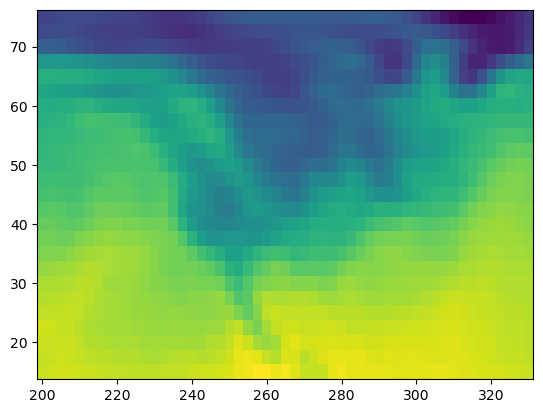

In [17]:
plt.figure()
plt.pcolormesh(lon, lat, temp[0, :, :]);

In [18]:
temp.mean(axis=1)  ## what did I just do? I can't tell by looking at this line.

array([[279.39798, 279.6664 , 279.66122, ..., 279.9508 , 280.31522,
        280.6624 ],
       [279.05722, 279.538  , 279.7296 , ..., 279.77563, 280.27002,
        280.79764],
       [279.0104 , 279.2808 , 279.5508 , ..., 279.682  , 280.19763,
        280.81403],
       ...,
       [279.63   , 279.934  , 280.534  , ..., 279.802  , 280.346  ,
        280.77798],
       [279.398  , 279.66602, 280.31796, ..., 279.766  , 280.34198,
        280.834  ],
       [279.27   , 279.354  , 279.88202, ..., 279.42596, 279.96997,
        280.48196]], dtype=float32)

### Analysis with xarray

Much more readable:

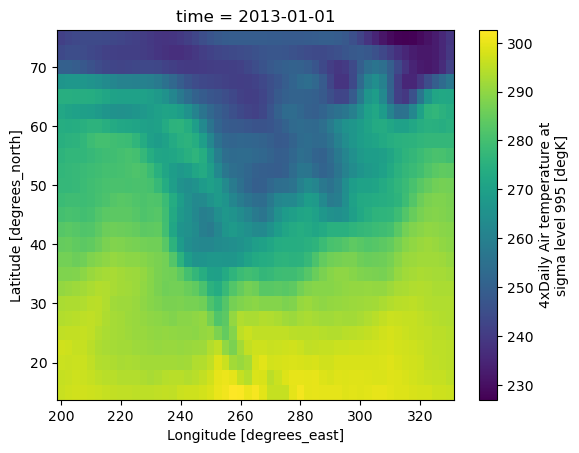

In [20]:
ds.air.isel(time=0).plot(x="lon");

Use dimension names instead of axis numbers


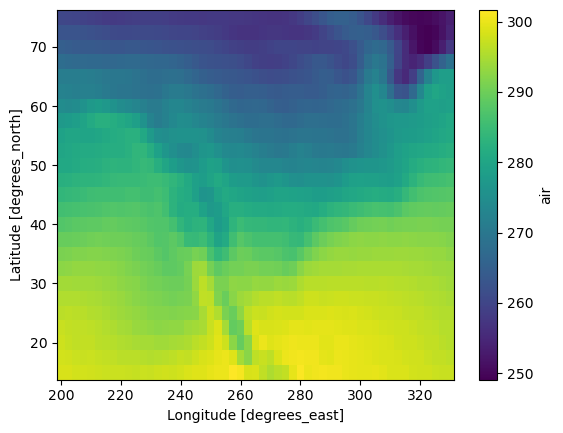

In [21]:
ds.air.mean(dim="time").plot(x="lon")

## Extracting data and indexing

Xarray supports

- label-based indexing using `.sel`
- position-based indexing using `.isel`

See the [user guide](https://docs.xarray.dev/en/stable/indexing.html) for more.

### Label-based indexing

Xarray inherits its label-based indexing rules from pandas; this means great
support for dates and times!


In [22]:
# here's what ds looks like
ds

<xarray.Dataset>
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 241.2 242.5 243.5 ... 296.5 296.2 295.7
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

In [24]:
# pull out data for all of 2013-May
ds.sel(time="2013-05")

<xarray.Dataset>
Dimensions:  (lat: 25, time: 124, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-05-01 ... 2013-05-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 259.2 259.3 259.1 ... 298.2 297.6 297.5
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

In [25]:
# demonstrate slicing
ds.sel(time=slice("2013-05", "2013-07"))

<xarray.Dataset>
Dimensions:  (lat: 25, time: 368, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-05-01 ... 2013-07-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 259.2 259.3 259.1 ... 299.4 299.5 299.7
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

In [26]:
ds.sel(time="2013")

<xarray.Dataset>
Dimensions:  (lat: 25, time: 1460, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2013-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 241.2 242.5 243.5 ... 296.1 295.1 294.7
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

In [27]:
# demonstrate "nearest" indexing
ds.sel(lon=240.2, method="nearest")

<xarray.Dataset>
Dimensions:  (lat: 25, time: 2920)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
    lon      float32 240.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat) float32 239.6 237.2 240.1 249.0 ... 294.8 296.9 298.4
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

In [24]:
# "nearest indexing at multiple points"
ds.sel(lon=[240.125, 234], lat=[40.3, 50.3], method="nearest")

<xarray.Dataset> Size: 117kB
Dimensions:  (lat: 2, time: 2920, lon: 2)
Coordinates:
  * lat      (lat) float32 8B 40.0 50.0
  * lon      (lon) float32 8B 240.0 235.0
  * time     (time) datetime64[ns] 23kB 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float64 93kB 268.1 283.0 265.5 ... 256.8 268.6
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

### Position-based indexing

This is similar to your usual numpy `array[0, 2, 3]` but with the power of named
dimensions!


In [25]:
ds.air.data[0, 2, 3]

247.5

In [26]:
# pull out time index 0, lat index 2, and lon index 3
ds.air.isel(time=0, lat=2, lon=3)  #  much better than ds.air[0, 2, 3]

<xarray.DataArray 'air' ()> Size: 8B
array(247.5)
Coordinates:
    lat      float32 4B 70.0
    lon      float32 4B 207.5
    time     datetime64[ns] 8B 2013-01-01
Attributes:
    long_name:      4xDaily Air temperature at sigma level 995
    units:          degK
    precision:      2
    GRIB_id:        11
    GRIB_name:      TMP
    var_desc:       Air temperature
    dataset:        NMC Reanalysis
    level_desc:     Surface
    statistic:      Individual Obs
    parent_stat:    Other
    actual_range:   [185.16 322.1 ]
    modified_with:  xarray

In [27]:
# demonstrate slicing
ds.air.isel(lat=slice(10))

<xarray.DataArray 'air' (time: 2920, lat: 10, lon: 53)> Size: 12MB
array([[[241.2 , 242.5 , 243.5 , ..., 232.8 , 235.5 , 238.6 ],
        [243.8 , 244.5 , 244.7 , ..., 232.8 , 235.3 , 239.3 ],
        [250.  , 249.8 , 248.89, ..., 233.2 , 236.39, 241.7 ],
        ...,
        [274.79, 275.2 , 275.6 , ..., 277.2 , 277.  , 277.  ],
        [275.9 , 276.9 , 276.9 , ..., 280.9 , 280.5 , 279.7 ],
        [276.7 , 277.4 , 277.7 , ..., 283.29, 284.1 , 283.9 ]],

       [[242.1 , 242.7 , 243.1 , ..., 232.  , 233.6 , 235.8 ],
        [243.6 , 244.1 , 244.2 , ..., 231.  , 232.5 , 235.7 ],
        [253.2 , 252.89, 252.1 , ..., 230.8 , 233.39, 238.5 ],
        ...,
        [274.  , 274.4 , 275.1 , ..., 280.1 , 280.7 , 280.79],
        [275.6 , 276.1 , 276.29, ..., 280.6 , 282.  , 282.9 ],
        [275.79, 276.  , 276.5 , ..., 282.9 , 284.1 , 285.29]],

       [[242.3 , 242.2 , 242.3 , ..., 234.3 , 236.1 , 238.7 ],
        [244.6 , 244.39, 244.  , ..., 230.3 , 232.  , 235.7 ],
        [256.2 , 255.5 , 254.2 , ..., 231.2 , 233.2 , 238.2 ],
        ...,
...
        ...,
        [275.79, 276.29, 277.39, ..., 274.99, 275.79, 277.09],
        [277.99, 278.49, 278.69, ..., 274.59, 275.59, 276.69],
        [277.49, 277.59, 278.19, ..., 274.89, 276.59, 278.19]],

       [[245.79, 244.79, 243.49, ..., 243.29, 243.99, 244.79],
        [249.89, 249.29, 248.49, ..., 241.29, 242.49, 244.29],
        [262.39, 261.79, 261.29, ..., 240.49, 243.09, 246.89],
        ...,
        [275.59, 276.29, 277.49, ..., 275.19, 275.79, 276.59],
        [276.89, 277.89, 278.69, ..., 273.59, 274.29, 275.29],
        [276.79, 277.29, 278.29, ..., 274.19, 275.39, 276.89]],

       [[245.09, 244.29, 243.29, ..., 241.69, 241.49, 241.79],
        [249.89, 249.29, 248.39, ..., 239.59, 240.29, 241.69],
        [262.99, 262.19, 261.39, ..., 239.89, 242.59, 246.29],
        ...,
        [274.29, 274.49, 275.59, ..., 274.69, 274.99, 275.39],
        [276.79, 277.49, 277.99, ..., 273.19, 273.59, 274.19],
        [276.89, 277.29, 277.59, ..., 273.79, 274.99, 276.19]]])
Coordinates:
  * lat      (lat) float32 40B 75.0 72.5 70.0 67.5 65.0 62.5 60.0 57.5 55.0 52.5
  * lon      (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
  * time     (time) datetime64[ns] 23kB 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    long_name:      4xDaily Air temperature at sigma level 995
    units:          degK
    precision:      2
    GRIB_id:        11
    GRIB_name:      TMP
    var_desc:       Air temperature
    dataset:        NMC Reanalysis
    level_desc:     Surface
    statistic:      Individual Obs
    parent_stat:    Other
    actual_range:   [185.16 322.1 ]
    modified_with:  xarray

## Exercise 1

Load the air temperature dataset and plot a time-series of the temperature in San Diego (latitude 32.7157°N and longitude 117.1611°W). 


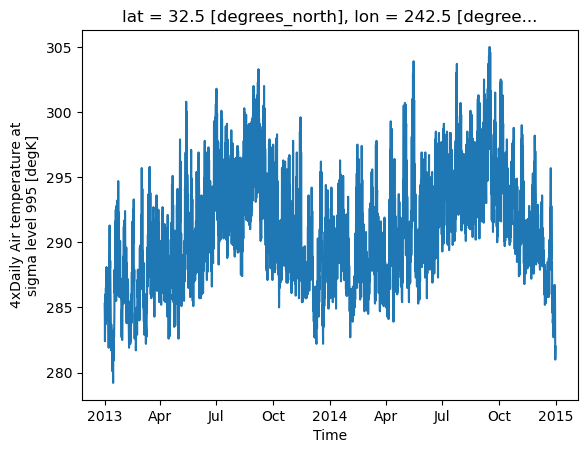

In [34]:
ds1 = xr.tutorial.load_dataset("air_temperature")
ds1.air.sel(lat=32.7157, lon=360-117.1611, method="nearest").plot();

Now try using linear interpolation, does it make a difference? (You'll have to look this up in the docs)

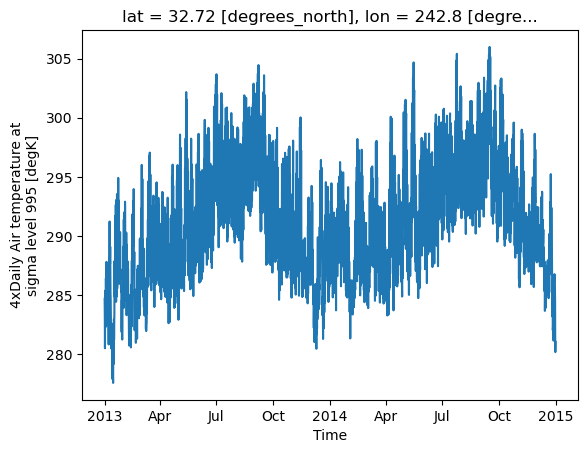

In [35]:
ds1.air.interp(lat=32.7157, lon=360-117.1611).plot()

# Reading image data

Many applications in environmental sciences involve working with image data. Here we will briefly look at reading and manipulate image data using the Python Image Library ([PIL](https://pillow.readthedocs.io/en/stable/handbook/index.html)). 

Note, other useful libraries include `rasterio` to read and write raster data, and  `opencv` and `scikit-image` for image processing. We won't cover those here though.

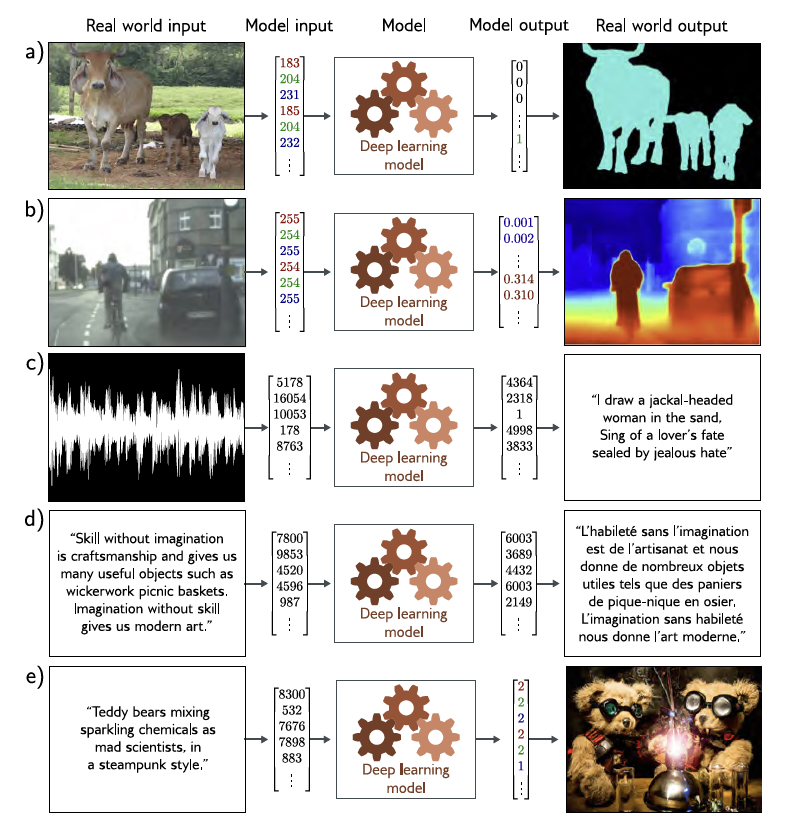

In [36]:
from PIL import Image
img = Image.open("_images/advanced_supervised.jpg")
img

## Handling PIL images

`PIL` image objects have a number of useful methods and attributes. Here we'll look at a few of them.

We can determine the image size, format, and mode using the `size`, `format`, and `mode` attributes, respectively:

In [37]:
img.size, img.format, img.mode

((787, 832), 'JPEG', 'RGB')

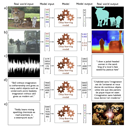

In [38]:
img.resize((128, 128))

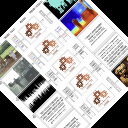

In [39]:
img.resize((128, 128)).rotate(45) # degrees counter-clockwise

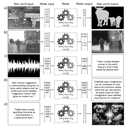

In [40]:
img.resize((128, 128)).convert('L')

## Handling image data

We can also treat these images as numpy arrays. This allows us to perform operations on the image data using numpy functions:

In [41]:
print(np.asarray(img).shape)

(832, 787, 3)


In [42]:
np.asarray(img.convert('RGBA')).shape

(832, 787, 4)

## Handling image data

Because the image is a `numpy` array, we can also easily treat them as `xarray` objects:

In [43]:
import xarray as xr
da_img  = xr.DataArray(img, dims=("y", "x", "channel"), 
                       coords={"y": np.arange(img.size[1], 0, -1), 
                               "x": np.arange(img.size[0]), 
                               "channel": ["r", "g", "b"]} )

In [44]:
da_img

<xarray.DataArray (y: 832, x: 787, channel: 3)>
array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
...
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
Coordinates:
  * y        (y) int32 832 831 830 829 828 827 826 825 824 ... 9 8 7 6 5 4 3 2 1
  * x        (x) int32 0 1 2 3 4 5 6 7 8 ... 778 779 780 781 782 783 784 785 786
  * channel  (channel) <U1 'r' 'g' 'b'

## Handling image data

Now we can easily perform xarray operations on the image data. For example, we can calculate the variance of the image data across the channels:

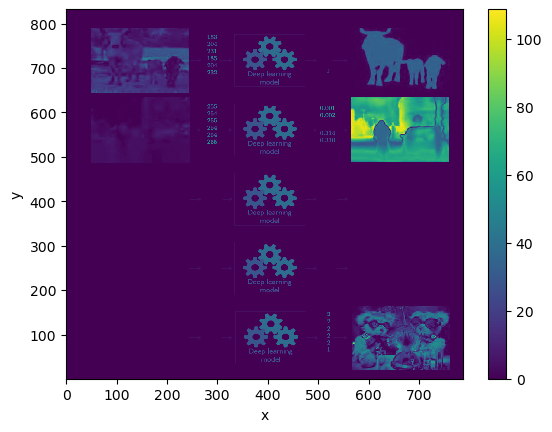

In [45]:
da_img.std('channel').plot.imshow()

Or pick out specific regions:

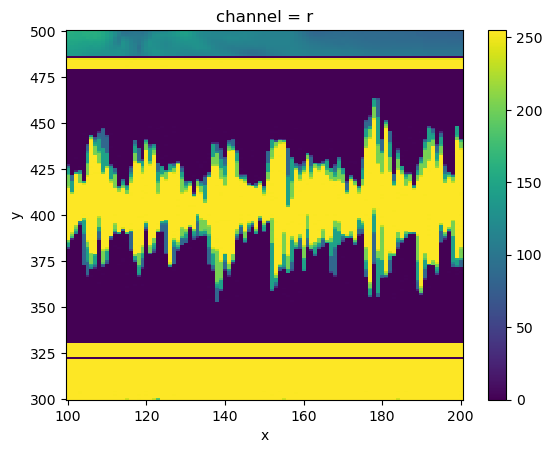

In [46]:
da_img.sel(x=slice(100,200), y=slice(500,300), channel='r').plot()

## Handling image data

Often in our machine learning pipelines we will want to stack multiple images or data samples together. Let's first read another example image:

In [47]:
img2 = Image.open("_images/supervised_general.jpg")

da_img2  = xr.DataArray(img2, dims=("y", "x", "channel"), 
                       coords={"y": np.arange(img2.size[1], 0, -1), 
                               "x": np.arange(img2.size[0]), 
                               "channel": ["r", "g", "b"]} )

Now we can use the `xr.concat` function to stack the two images together:

In [49]:
X_data = xr.concat([da_img, da_img2], dim="sample")
X_data

<xarray.DataArray (sample: 2, y: 833, x: 787, channel: 3)>
array([[[[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.]],

        [[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.]],

        [[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
...
         ...,
         [ nan,  nan,  nan],
         [ nan,  nan,  nan],
         [ nan,  nan,  nan]],

        [[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [ nan,  nan,  nan],
         [ nan,  nan,  nan],
         [ nan,  nan,  nan]],

        [[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [ nan,  nan,  nan],
         [ nan,  nan,  nan],
         [ nan,  nan,  nan]]]], dtype=float32)
Coordinates:
  * y        (y) int32 1 2 3 4 5 6 7 8 9 ... 825 826 827 828 829 830 831 832 833
  * x        (x) int32 0 1 2 3 4 5 6 7 8 ... 778 779 780 781 782 783 784 785 786
  * channel  (channel) <U1 'r' 'g' 'b'
Dimensions without coordinates: sample

##  Handling missing data
 
Notice that because the two images above are slightly different shapes `xarray` has automatically broadcast the smaller image to the larger image. This is a very useful feature of `xarray` that makes working with image data much easier.

In doing so, it has filled the missing data with `nan` values. This is a common way to handle missing data in `xarray` and is very useful for many applications, but it can also cause problems in ML pipelines when e.g. calculating the loss function.

The solution is very much problem dependent, but some common approaches include:
 - Removing the missing data, by e.g. cropping the images
 - Resizing the data to the same shape before concatenating them
 - Filling the missing data with a constant value (`da.fillna()`)
 - Filling the missing data with the mean or median value (`da.fillna(da.mean())`)
 - Interpolating the missing data (`da.interpolate_na()`) 

## Data layout, one-hot encoding etc.


Different machine learning algorithms require different data layouts. For example, many deep learning algorithms require the data to be in a specific format, such as a 4D tensor for image data. Simpler models might require the data to be in a 2D matrix format.

Again, xarray can make these conversions very easy. For example, we can easily flatten the image data to a 2D matrix:

In [50]:
X_data.mean('channel').stack(flatxy=("y", "x"))


<xarray.DataArray (sample: 2, flatxy: 655571)>
array([[255., 255., 255., ...,  nan,  nan,  nan],
       [255., 255., 255., ...,  nan,  nan,  nan]], dtype=float32)
Coordinates:
  * flatxy   (flatxy) object MultiIndex
  * y        (flatxy) int32 1 1 1 1 1 1 1 1 ... 833 833 833 833 833 833 833 833
  * x        (flatxy) int32 0 1 2 3 4 5 6 7 ... 779 780 781 782 783 784 785 786
Dimensions without coordinates: sample

## One-hot encoding


When handling multiple classes in a classification problem, it is often useful to encode the classes as one-hot vectors. This is a vector where all elements are zero except for one element which is one.

This is in contrast to a "label" encoding where the classes are simply encoded as integers.

`sklearn` provides a host of useful tools for these kind of tasks which can be combined with models to form a '[Pipeline](https://scikit-learn.org/stable/modules/compose.html)'. These can be very powerful, but I find them quite cumbersome to work with so I often use `pandas` and `xarray` to handle these tasks instead.

## One-hot encoding

For example, we can use the `pd.get_dummies` function to convert a pandas series of labels to a one-hot encoded matrix:

In [51]:
import pandas as pd
# Sample xarray Dataset with a 'category' dimension
df = pd.DataFrame({
    'data': [1, 2, 3, 1, 2, 4],
    'category': ['A', 'B', 'C', 'A', 'B', 'D']
})
df

,data,category
0,1,A
1,2,B
2,3,C
3,1,A
4,2,B
5,4,D


In [55]:
# Apply one-hot encoding
encoded_df = pd.get_dummies(df, columns=['category'], dtype=bool) #dtype can be int
encoded_df

,data,category_A,category_B,category_C,category_D
0,1,True,False,False,False
1,2,False,True,False,False
2,3,False,False,True,False
3,1,True,False,False,False
4,2,False,True,False,False
5,4,False,False,False,True


## One-hot encoding images

Let's take a look at how we can use `xarray` to one-hot encode image data. First, we need to load an image with multiple classes. Here we'll use a compressed version of our test image:

In [56]:
da_img2_bit  = xr.DataArray(img2.convert('P'), dims=("y", "x"), 
                       coords={"y": np.arange(img2.size[1], 0, -1), 
                               "x": np.arange(img2.size[0])} )

In [57]:
da_img2_bit

<xarray.DataArray (y: 833, x: 779)>
array([[225, 225, 225, ..., 225, 225, 225],
       [225, 225, 225, ..., 225, 225, 225],
       [225, 225, 225, ..., 225, 225, 225],
       ...,
       [225, 225, 225, ..., 225, 225, 225],
       [225, 225, 225, ..., 225, 225, 225],
       [225, 225, 225, ..., 225, 225, 225]], dtype=uint8)
Coordinates:
  * y        (y) int32 833 832 831 830 829 828 827 826 825 ... 9 8 7 6 5 4 3 2 1
  * x        (x) int32 0 1 2 3 4 5 6 7 8 ... 770 771 772 773 774 775 776 777 778

## One-hot encoding images

Now we convert that to a dataframe:

In [58]:
df=da_img2_bit.to_dataframe(name='img')
df

img
y   x       
833 0    225
    1    225
    2    225
    3    225
    4    225
...      ...
1   774  225
    775  225
    776  225
    777  225
    778  225

[648907 rows x 1 columns]

And then one-hot encode the data and convert it back to an xarray object:

In [59]:
encoded_df = pd.get_dummies(df, columns=['img'], prefix='', prefix_sep='')
encoded_ds = encoded_df.to_xarray() 
encoded_ds

<xarray.Dataset>
Dimensions:  (y: 833, x: 779)
Coordinates:
  * y        (y) int64 833 832 831 830 829 828 827 826 825 ... 9 8 7 6 5 4 3 2 1
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 770 771 772 773 774 775 776 777 778
Data variables: (12/83)
    0        (y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    11       (y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    12       (y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    16       (y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    17       (y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    18       (y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    ...       ...
    212      (y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    217      (y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    218      (y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    219      (y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    224      (y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    225      (y, x) uint8 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1

## One-hot encoding images

How do we convert the multiple data variables to a single variable with multiple dimensions?

In [60]:
encoded_da = encoded_ds.to_dataarray(dim='category')

# And let's also make the category an int type
encoded_da.coords['category'] = encoded_da.coords['category'].astype(int)
encoded_da

<xarray.DataArray (category: 83, y: 833, x: 779)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
...
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]]], dtype=uint8)
Coordinates:
  * y         (y) int64 833 832 831 830 829 828 827 826 825 ... 8 7 6 5 4 3 2 1
  * x         (x) int64 0 1 2 3 4 5 6 7 8 ... 771 772 773 774 775 776 777 778
  * category  (category) int32 0 11 12 16 17 18 19 ... 212 217 218 219 224 225

## Exercise 2

Convert this one-hot encoded dataset back to the original image data.

In [61]:
encoded_da.idxmax('category')

<xarray.DataArray 'category' (y: 833, x: 779)>
array([[225, 225, 225, ..., 225, 225, 225],
       [225, 225, 225, ..., 225, 225, 225],
       [225, 225, 225, ..., 225, 225, 225],
       ...,
       [225, 225, 225, ..., 225, 225, 225],
       [225, 225, 225, ..., 225, 225, 225],
       [225, 225, 225, ..., 225, 225, 225]])
Coordinates:
  * y        (y) int64 833 832 831 830 829 828 827 826 825 ... 9 8 7 6 5 4 3 2 1
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 770 771 772 773 774 775 776 777 778

## Data scaling and normalization

Again, `sklearn` has tools and pipelines to do this, but with `pandas` and `xarray` it is very easy to do this manually:

In [70]:
X_scaled = (X_data.max('sample') - X_data) / (X_data.max('sample') - X_data.min('sample'))

In [63]:
X_scaled.min(['x', 'y', 'channel']), X_scaled.max(['x', 'y', 'channel'])

(<xarray.DataArray (sample: 2)>
 array([0., 0.], dtype=float32)
 Dimensions without coordinates: sample,
 <xarray.DataArray (sample: 2)>
 array([1., 1.], dtype=float32)
 Dimensions without coordinates: sample)

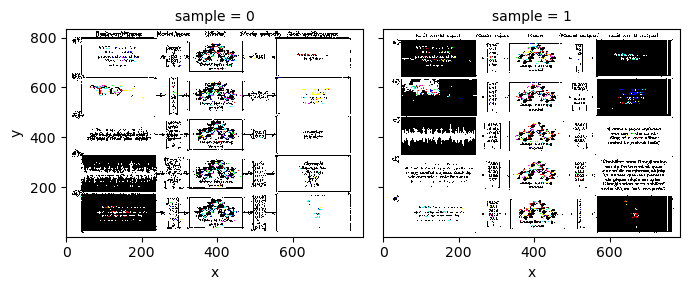

In [64]:
X_scaled.plot.imshow(col='sample', col_wrap=2)

In [65]:
X_normed = (X_data - X_data.mean('sample')) / X_data.std('sample')

In [66]:
X_scaled.mean(['x', 'y', 'channel']), X_scaled.std(['x', 'y', 'channel'])

(<xarray.DataArray (sample: 2)>
 array([0.62144727, 0.3785527 ], dtype=float32)
 Dimensions without coordinates: sample,
 <xarray.DataArray (sample: 2)>
 array([0.48502642, 0.4850265 ], dtype=float32)
 Dimensions without coordinates: sample)

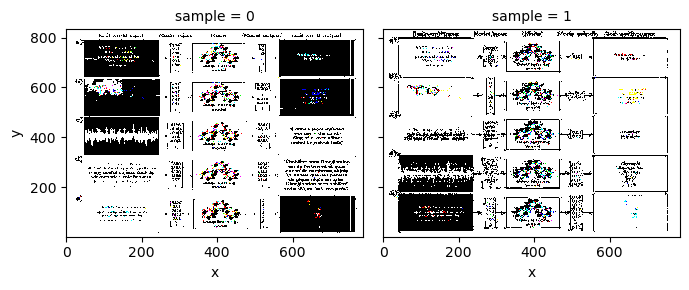

In [67]:
X_normed.plot.imshow(col='sample', col_wrap=2)

##  Feature selection


In machine learning we usually have a lot of data, and not all of it is useful. Feature selection is the process of selecting a subset of relevant features for use in model construction. Feature selection techniques are used for several reasons:
 - simplification of models to make them easier to interpret by researchers/users,
 - shorter training times,
 - to avoid the curse of dimensionality,
 - to improve the accuracy of a model by removing irrelevant features or noise.

##  Feature selection


There are many different feature selection techniques, but here we'll look at a few simple ones:
 - Removing features with low variance
 - Univariate feature selection such as `SelectKBest`
 - Akaike / Bayesian information criterion (AIC / BIC)

These all make some assumptions about the data though, so it is important to understand the data and the assumptions of the feature selection technique before using it. For deep learning models, feature selection is often not necessary as the model can learn the relevant features itself.